In [3]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex

# The Quantum Teleportation Protocol
https://qiskit.org/textbook/ch-algorithms/teleportation.html

In [37]:
def create_bell_pair(qc, a, b):
    '''create a bell pair in qc using qubits a & b
    '''
    qc.h(a)
    qc.cx(a, b)

## Step 1: A third party (Telamon) creates entangled qubits q1 and q2 and gives to Alice and Bob respectively

In [51]:
# some resigters form a circuit
qr = QuantumRegister(3, name='q')
crz, crx = ClassicalRegister(1, name='crz'), ClassicalRegister(1, name='crx')
qc = QuantumCircuit(qr, crz, crx)

# step 1
create_bell_pair(qc, 1, 2)
qc.draw()

q_0: ──────────
       ┌───┐     
  q_1: ┤ H ├──■──
       └───┘┌─┴─┐
  q_2: ─────┤ X ├
            └───┘
crz: 1/══════════
                 
crx: 1/══════════

##  Step 2: Alice applies a CNOT gate to q1, controlled by ket psi (the qubit she is trying to send Bob). Then Alice applies a Hadamard gate to ket psi.

In [43]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [47]:
qr = QuantumRegister(3, name='q')
crz, crx = ClassicalRegister(1, name='crz'), ClassicalRegister(1, name='crx')
qc = QuantumCircuit(qr, crz, crx)

# step 1
create_bell_pair(qc, 1, 2)

# step 2
qc.barrier()
alice_gates(qc, 0, 1)
qc.draw()

░      ┌───┐
  q_0: ───────────░───■──┤ H ├
       ┌───┐      ░ ┌─┴─┐└───┘
  q_1: ┤ H ├──■───░─┤ X ├─────
       └───┘┌─┴─┐ ░ └───┘     
  q_2: ─────┤ X ├─░───────────
            └───┘ ░           
crz: 1/═══════════════════════
                              
crx: 1/═══════════════════════

## Step 3: Alice applies a measurement to both qubits that she owns, q1 and ket psi and stores this result in two classical bits. She then sends these two bits to Bob

In [49]:
def measure_and_send(qc, a, b):
    '''Measures qubits a & b and 'sends' the results to Bob
    '''
    qc.barrier()
    qc.measure(a, 0)
    qc.measure(b, 1)

In [50]:
qr = QuantumRegister(3, name='q')
crz, crx = ClassicalRegister(1, name='crz'), ClassicalRegister(1, name='crx')
qc = QuantumCircuit(qr, crz, crx)

# step 1
create_bell_pair(qc, 1, 2)

# step 2
qc.barrier()
alice_gates(qc, 0, 1)

# step 3
measure_and_send(qc, 0, 1)
qc.draw()

░      ┌───┐ ░ ┌─┐   
  q_0: ───────────░───■──┤ H ├─░─┤M├───
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘
  q_2: ─────┤ X ├─░────────────░──╫──╫─
            └───┘ ░            ░  ║  ║ 
crz: 1/═══════════════════════════╩══╬═
                                  0  ║ 
                                     ║ 
crx: 1/══════════════════════════════╩═
                                     0

## Step 4: Bob, who already has the qubit q2, then applies the following gates depending on the state of the classical bits

In [52]:
def bob_gates(qc, qubit, crz, crx):
    qc.x(qubit).c_if(crx, 1) # apply gates if the registers are in the state 1
    qc.z(qubit).c_if(crz, 1)

In [53]:
qr = QuantumRegister(3, name='q')
crz, crx = ClassicalRegister(1, name='crz'), ClassicalRegister(1, name='crx')
qc = QuantumCircuit(qr, crz, crx)

# step 1
create_bell_pair(qc, 1, 2)

# step 2
qc.barrier()
alice_gates(qc, 0, 1)

# step 3
measure_and_send(qc, 0, 1)

# step 4
qc.barrier()
bob_gates(qc, 2, crz, crx)
qc.draw()

░      ┌───┐ ░ ┌─┐    ░               
  q_0: ───────────░───■──┤ H ├─░─┤M├────░───────────────
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░               
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───────────────
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
  q_2: ─────┤ X ├─░────────────░──╫──╫──░──┤ X ├──┤ Z ├─
            └───┘ ░            ░  ║  ║  ░  └─┬─┘  └─┬─┘ 
                                  ║  ║       │   ┌──┴──┐
crz: 1/═══════════════════════════╩══╬═══════╪═══╡ = 1 ╞
                                  0  ║    ┌──┴──┐└─────┘
crx: 1/══════════════════════════════╩════╡ = 1 ╞═══════
                                     0    └─────┘

# Simulating the Teleportation Protocol

<IPython.core.display.Math object>

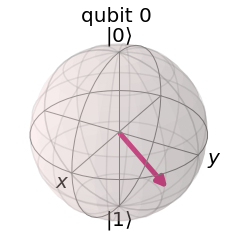

In [80]:
psi = random_state(1)
array_to_latex(psi, pretext="|\\psi\\rangle =")
plot_bloch_multivector(psi)

In [81]:
init_gate = Initialize(psi)
init_gate.label = "init"

qr = QuantumRegister(3, name='q')
crz, crx = ClassicalRegister(1, name='crz'), ClassicalRegister(1, name='crx')
qc = QuantumCircuit(qr, crz, crx)

# step 0
qc.append(init_gate, [0])  # set Alice to psi
qc.barrier()

# step 1
create_bell_pair(qc, 1, 2)

# step 2
qc.barrier()
alice_gates(qc, 0, 1)

# step 3
measure_and_send(qc, 0, 1)

# step 4
qc.barrier()
bob_gates(qc, 2, crz, crx)  # now psi is teleported to Bob
qc.draw()

┌──────┐ ░            ░      ┌───┐ ░ ┌─┐    ░               
  q_0: ┤ init ├─░────────────░───■──┤ H ├─░─┤M├────░───────────────
       └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░               
  q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───────────────
                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
  q_2: ─────────░──────┤ X ├─░────────────░──╫──╫──░──┤ X ├──┤ Z ├─
                ░      └───┘ ░            ░  ║  ║  ░  └─┬─┘  └─┬─┘ 
                                             ║  ║       │   ┌──┴──┐
crz: 1/══════════════════════════════════════╩══╬═══════╪═══╡ = 1 ╞
                                             0  ║    ┌──┴──┐└─────┘
crx: 1/═════════════════════════════════════════╩════╡ = 1 ╞═══════
                                                0    └─────┘

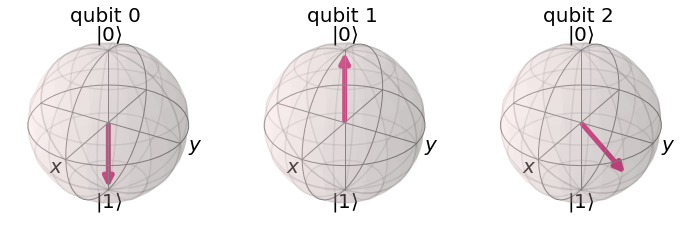

In [82]:
backend = BasicAer.get_backend('statevector_simulator')
out_vector = execute(qc, backend).result().get_statevector()
plot_bloch_multivector(out_vector)

# qubit 2 is the same as the psi = random_state(1)